In [10]:
import keras.models
import tensorflow as tf
import keras.layers as layers
from keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
import visualkeras as vk

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


## Dataset formatting

In [3]:
# Define the path to the directory containing the images
image_dir_train = '../chest_xray/train/'
image_dir_test = '../chest_xray/test/'

# Define the batch size and image size for the dataset
batch_size = 32
img_size = (224, 224)

# Use the tf.keras.preprocessing.image_dataset_from_directory function to create the dataset
print("training set")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_train,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_train,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

print("test set")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir_test,
    batch_size=batch_size,
    image_size=img_size,
    seed=123,
    shuffle=True,
)

training set
Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Metal device set to: Apple M1 Pro


2023-05-02 14:28:20.190350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 14:28:20.190766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
test set
Found 624 files belonging to 2 classes.


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with data augmentation and validation_split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Use 20% of the data for validation

# Use flow_from_directory method to load images and apply data augmentation for the training set
train_generator = datagen.flow_from_directory(
    image_dir_train,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')  # Use the 'training' subset

# Use flow_from_directory method to load images without data augmentation for the validation set
val_generator = datagen.flow_from_directory(
    image_dir_train,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')  # Use the 'validation' subset

test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    image_dir_test,  # Directory containing all images
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

train_steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
val_steps_per_epoch = math.ceil(val_generator.n / val_generator.batch_size)

print("train dataset images:", train_generator.n)
print("validation dataset images:", val_generator.n)
print("test dataset images:", test_generator.n)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
train dataset images: 4187
validation dataset images: 1045
test dataset images: 624


In [5]:
# Preprocessing

# Normalizing pixel values
train_dataset = train_dataset.map(lambda x, y: (x/255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x/255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x/255.0, y))

## Making model

In [9]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

## Training model

In [20]:
# Train the model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

'''
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])
'''


'\nhistory = model.fit(\n    train_generator,\n    steps_per_epoch=train_steps_per_epoch,\n    epochs=100,\n    validation_data=val_generator,\n    validation_steps=val_steps_per_epoch,\n    callbacks=[early_stopping])\n'

In [19]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print('Test accuracy:', test_accuracy)

NameError: name 'model' is not defined

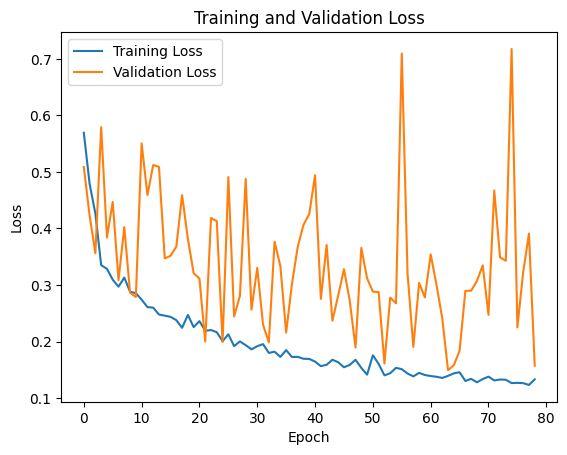

In [13]:
# Extract the metrics from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

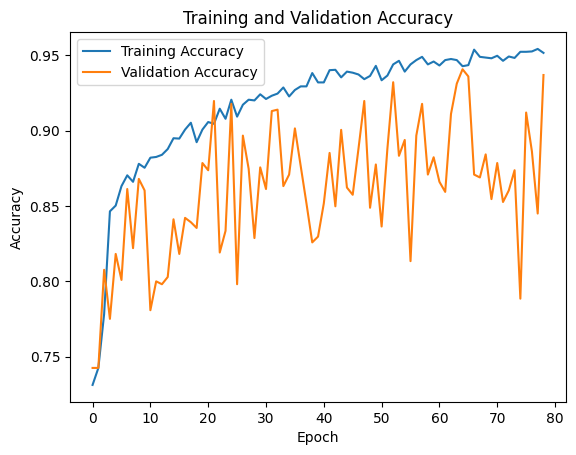

In [14]:
# Plot training and validation accuracy
plt.figure()
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
oldModel = keras.models.load_model('models/my_custom_model.h5')
old_test_loss, old_test_accuracy = oldModel.evaluate(test_generator)

#if old_test_accuracy < test_accuracy:
#    model.save('models/my_custom_model.h5')

2023-05-02 14:28:51.994196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 164ms/step - loss: 0.2324 - accuracy: 0.9199


In [ ]:
oldModel.summary()

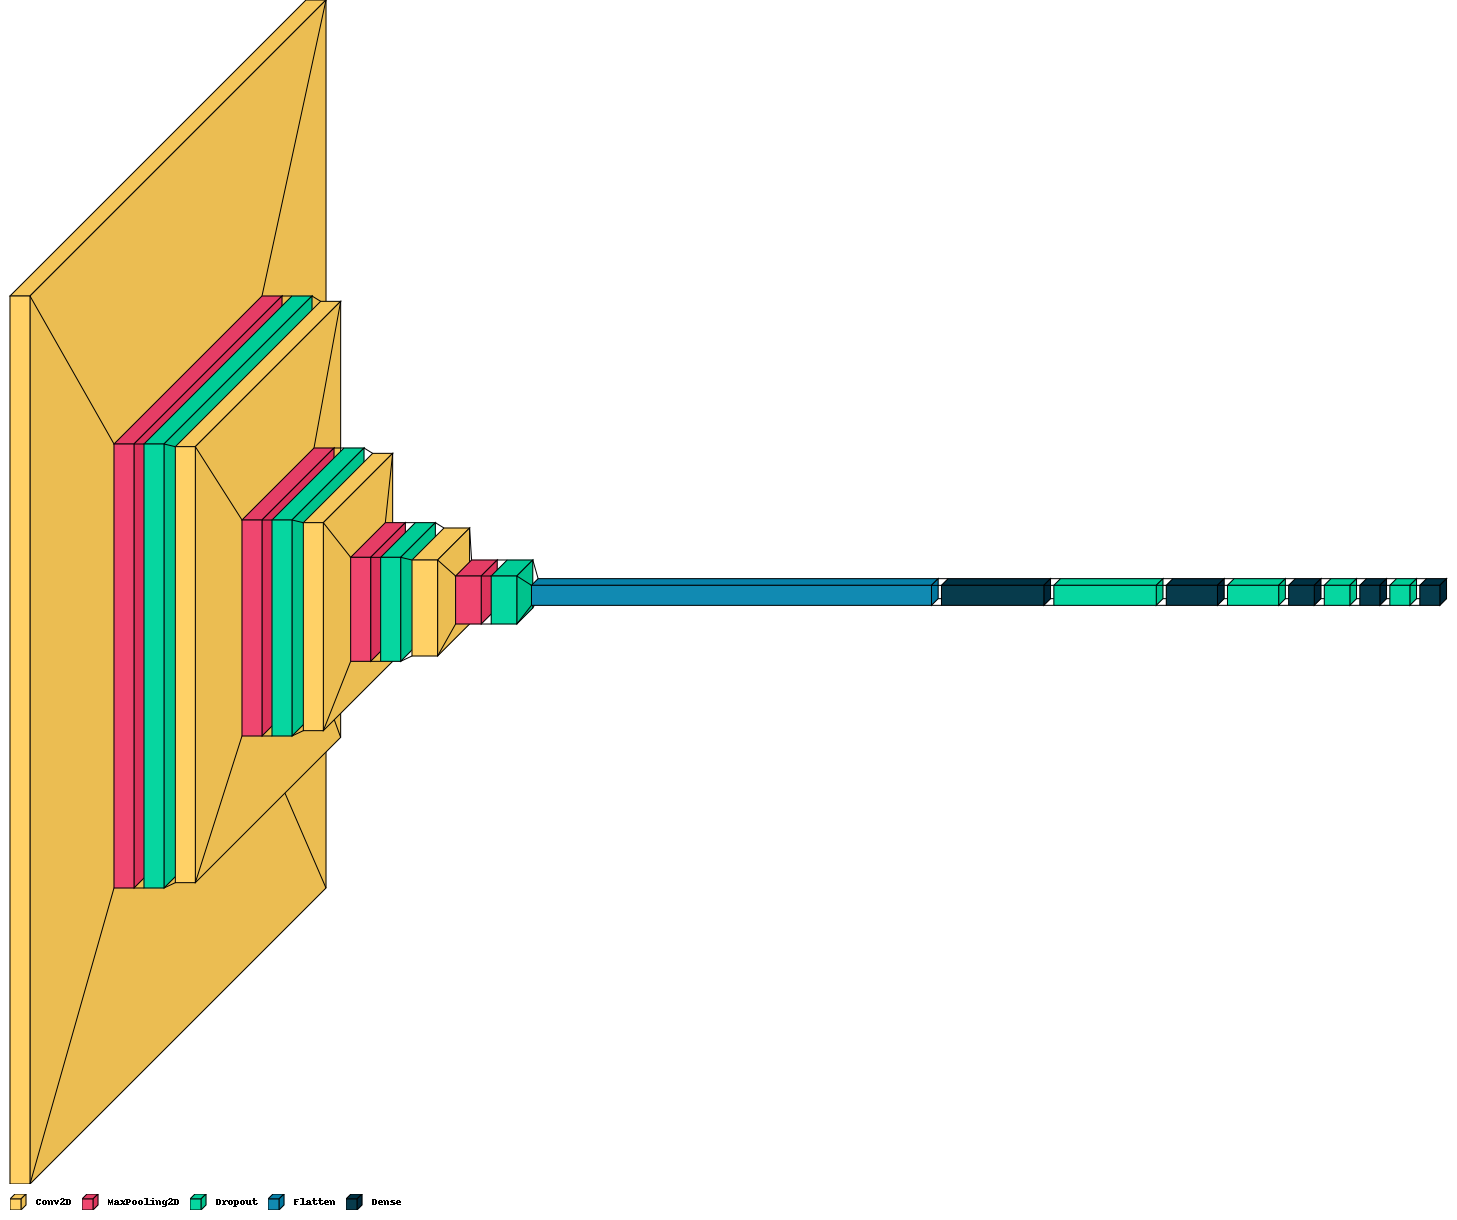

In [11]:
vk.layered_view(oldModel,legend=True, draw_volume=True)

In [ ]:
import copy
oldModel = keras.models.load_model('models/my_custom_model.h5')
old_test_loss, old_test_accuracy = oldModel.evaluate(test_generator)

newOldModel = copy.deepcopy(oldModel)

In [23]:

# Train the model
newOldModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = newOldModel.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=120,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/120


2023-04-20 14:47:29.831879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9362

2023-04-20 14:48:14.360120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 55s 418ms/step - loss: 0.1681 - accuracy: 0.9362 - val_loss: 0.1703 - val_accuracy: 0.9483
Epoch 2/120
131/131 [==============================] - 54s 413ms/step - loss: 0.1649 - accuracy: 0.9405 - val_loss: 0.1967 - val_accuracy: 0.9301
Epoch 3/120
131/131 [==============================] - 54s 412ms/step - loss: 0.1450 - accuracy: 0.9453 - val_loss: 0.1759 - val_accuracy: 0.9416
Epoch 4/120
131/131 [==============================] - 52s 399ms/step - loss: 0.1525 - accuracy: 0.9412 - val_loss: 0.3205 - val_accuracy: 0.8967
Epoch 5/120
131/131 [==============================] - 54s 409ms/step - loss: 0.1373 - accuracy: 0.9453 - val_loss: 0.2350 - val_accuracy: 0.9349
Epoch 6/120
131/131 [==============================] - 58s 446ms/step - loss: 0.1439 - accuracy: 0.9477 - val_loss: 0.2351 - val_accuracy: 0.8947
Epoch 7/120
131/131 [==============================] - 56s 430ms/step - loss: 0.1472 - accuracy: 0.9446 - val_loss: 0.1739 - val_accurac

In [24]:
newOldModel.evaluate(test_generator)

20/20 [==============================] - 3s 171ms/step - loss: 0.2363 - accuracy: 0.9119


[0.23633328080177307, 0.9118589758872986]